<a href="https://colab.research.google.com/github/Pmskabir1234/Torch/blob/main/transferred_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: saadkabir010804
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 1.47GB/s]

In [2]:
import torch
from torch import nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import numpy as np
from torch.optim import Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
train_df = pd.read_csv('/content/bean-leaf-lesions-classification/train.csv')
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")
train_df.head(10)

,image:FILE,category
0,train/healthy/healthy_train.98.jpg,0
1,train/healthy/healthy_train.148.jpg,0
2,train/healthy/healthy_train.306.jpg,0
3,train/healthy/healthy_train.305.jpg,0
4,train/healthy/healthy_train.40.jpg,0
5,train/healthy/healthy_train.200.jpg,0
6,train/healthy/healthy_train.295.jpg,0
7,train/healthy/healthy_train.158.jpg,0
8,train/healthy/healthy_train.6.jpg,0
9,train/healthy/healthy_train.73.jpg,0


In [4]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [33]:
base_image_path = './bean-leaf-lesions-classification/'
class CustomDataset(Dataset):
  def __init__(self, dataframe, transform, root_dir):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(dataframe['category']).to(device)
    self.root_dir = root_dir

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_name = self.dataframe.loc[idx, 'image:FILE']
    img_path = os.path.join(self.root_dir, img_name)
    label = self.labels[idx]
    image = Image.open(img_path).convert("RGB")
    if self.transform:
      image = (self.transform(image)/255.0).to(device)
    return image, label

In [34]:
train_dataset = CustomDataset(train_df, transform, base_image_path)
val_dataset = CustomDataset(val_df, transform, base_image_path)

Let's take a look into image data that we have

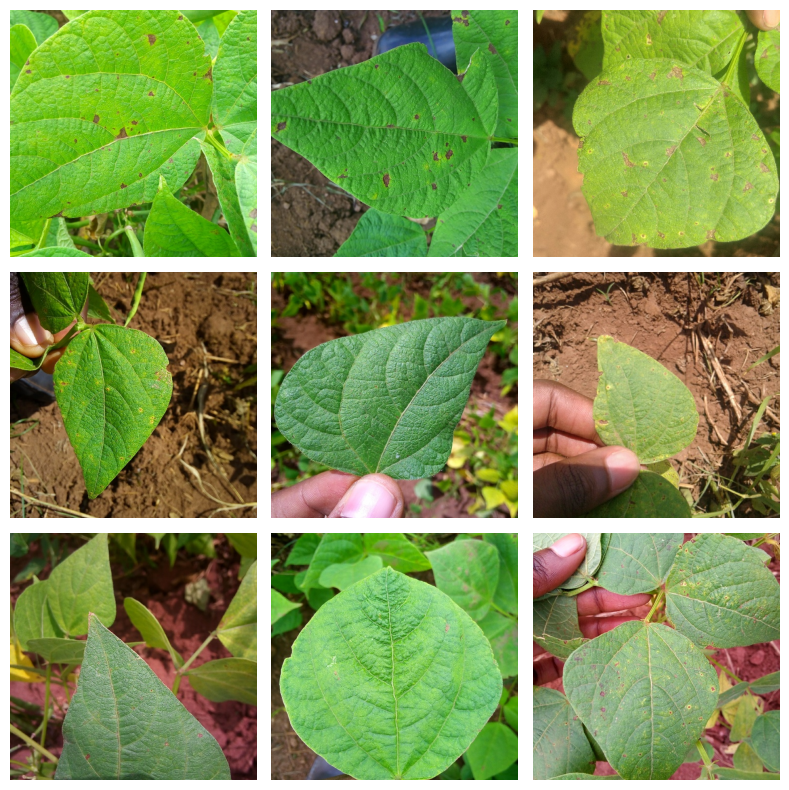

In [35]:
import random
n_rows = 3
n_cols = 3
f,axarr = plt.subplots(n_rows, n_cols, figsize=(8, 8))

for row in range(n_rows):
  for col in range(n_cols):
    idx = random.randint(0,val_df.shape[0] - 1)
    relative_image_path = val_df.loc[idx,'image:FILE']
    full_image_path = os.path.join(base_image_path, relative_image_path)
    image = Image.open(full_image_path).convert("RGB")
    axarr[row,col].imshow(image)
    axarr[row,col].axis('off')

plt.tight_layout()
plt.show()

In [36]:
train_data = DataLoader(train_dataset,batch_size=16, shuffle=True)
val_data = DataLoader(val_dataset,batch_size = 16, shuffle=True)

In [37]:
LR = 1e-3
EPOCHS = 15

Now, for the classification task we will use a pretrained model called "googlenet". We can access it from the 'models' library of 'torchvision' module.

In [38]:
googlenet_model = models.googlenet(weights='DEFAULT')

now we don't want the model to set the parameters randomly and learn gradually, instead we will tell the model to initiate the parameters from the previous knowlwdge. The will update the weights from the new hidden layers as we will train it on our data.  

In [39]:
for param in googlenet_model.parameters():
  param.requires_grad = True

"""   By setting 'requires_grad = True' for all parameters,
      you allow the model to adjust all its weights based on your specific data,
      even if it was pre-trained on a different dataset.
      This is a common approach when your dataset is large enough and similar to the pre-training data.
"""

In [40]:
#now will take a look into the last layer of the model
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

as we can see the last layer is a linear layer that has 1000 out_features. But in our case, we have only 3 classes. So we will change the architecture according to our requirement.

In [41]:
num_classes = len(train_df['category'].unique())
num_classes

3

In [42]:
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [43]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(),lr=LR)

In [46]:
total_train_loss_plot = []
total_train_acc_plot = []

for epoch in range(EPOCHS):
  total_train_loss = 0
  total_train_acc = 0
  for inputs,labels in train_data:

    optimizer.zero_grad()
    output = googlenet_model(inputs)
    train_loss = criterion(output, labels)
    total_train_loss += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(output, axis=1) == labels).sum().item()
    total_train_acc += train_acc
    optimizer.step()

  total_train_loss_plot.append(round(total_train_loss/1000, 4))
  total_train_acc_plot.append(round(total_train_acc/train_dataset.__len__()*100, 4))

  print(f"Epoch : {epoch+1}    Total Loss : {round(total_train_loss/1000, 4)}    Total Acc : {round(total_train_acc/train_dataset.__len__()*100, 4)}%")

Epoch : 1    Total Loss : 0.0092    Total Acc : 94.7776%
Epoch : 2    Total Loss : 0.0066    Total Acc : 96.7118%
Epoch : 3    Total Loss : 0.0062    Total Acc : 97.0019%
Epoch : 4    Total Loss : 0.0081    Total Acc : 95.0677%
Epoch : 5    Total Loss : 0.0113    Total Acc : 94.4874%
Epoch : 6    Total Loss : 0.0093    Total Acc : 95.4545%
Epoch : 7    Total Loss : 0.0046    Total Acc : 97.8723%
Epoch : 8    Total Loss : 0.0018    Total Acc : 99.323%
Epoch : 9    Total Loss : 0.0026    Total Acc : 98.9362%
Epoch : 10    Total Loss : 0.0008    Total Acc : 99.6132%
Epoch : 11    Total Loss : 0.0012    Total Acc : 99.7099%
Epoch : 12    Total Loss : 0.0045    Total Acc : 97.7756%
Epoch : 13    Total Loss : 0.0084    Total Acc : 95.3578%
Epoch : 14    Total Loss : 0.0088    Total Acc : 95.3578%
Epoch : 15    Total Loss : 0.0062    Total Acc : 96.325%


Text(0.5, 1.0, 'Accuracy')

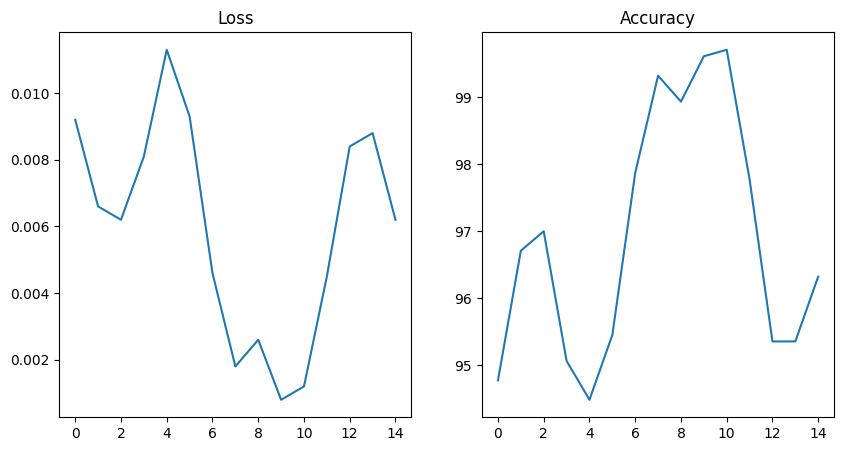

In [58]:
f, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].plot(total_train_loss_plot, label="Loss")
axs[0].set_title("Loss")


axs[1].plot(total_train_acc_plot, label="Accuracy")
axs[1].set_title("Accuracy")


In [59]:
with torch.no_grad():
  total_test_loss = 0
  total_test_acc = 0

  for inputs,labels in val_data:
    outputs = googlenet_model(inputs)

    acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_test_acc += acc

In [61]:
print(f'Total test accuracy: {round(total_test_acc/val_dataset.__len__()*100, 4)}%')

Total test accuracy: 86.4662%


##Transfer Learning
here we will change the architecture such a way that, we won't change/update all the weights during backprop of the model, we will only change/update the weights of the last layer.

In [64]:
gnet_model = models.googlenet(weights='DEFAULT')

for param in gnet_model.parameters():
  param.requires_grad = False

gnet_model.fc = torch.nn.Linear(gnet_model.fc.in_features, num_classes)
gnet_model.fc.requires_grad = True
gnet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [66]:
total_train_loss_plot = []
total_train_acc_plot = []

for epoch in range(EPOCHS):
  total_train_loss = 0
  total_train_acc = 0
  for inputs,labels in train_data:

    optimizer.zero_grad()
    output = gnet_model(inputs)
    train_loss = criterion(output, labels)
    total_train_loss += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(output, axis=1) == labels).sum().item()
    total_train_acc += train_acc
    optimizer.step()

  total_train_loss_plot.append(round(total_train_loss/1000, 4))
  total_train_acc_plot.append(round(total_train_acc/train_dataset.__len__()*100, 4))

  print(f"Epoch : {epoch+1}    Total Loss : {round(total_train_loss/1000, 4)}    Total Acc : {round(total_train_acc/train_dataset.__len__()*100, 4)}%")

Epoch : 1    Total Loss : 0.076    Total Acc : 28.53%
Epoch : 2    Total Loss : 0.0756    Total Acc : 29.0135%
Epoch : 3    Total Loss : 0.0757    Total Acc : 28.4333%
Epoch : 4    Total Loss : 0.0761    Total Acc : 28.7234%
Epoch : 5    Total Loss : 0.0761    Total Acc : 28.8201%
Epoch : 6    Total Loss : 0.0752    Total Acc : 29.9807%
Epoch : 7    Total Loss : 0.0764    Total Acc : 29.207%
Epoch : 8    Total Loss : 0.0753    Total Acc : 30.0774%
Epoch : 9    Total Loss : 0.0752    Total Acc : 28.7234%
Epoch : 10    Total Loss : 0.0752    Total Acc : 31.6248%
Epoch : 11    Total Loss : 0.0762    Total Acc : 27.5629%
Epoch : 12    Total Loss : 0.0758    Total Acc : 27.5629%
Epoch : 13    Total Loss : 0.0755    Total Acc : 29.3037%
Epoch : 14    Total Loss : 0.0758    Total Acc : 29.4971%
Epoch : 15    Total Loss : 0.0759    Total Acc : 29.7872%


In [67]:
with torch.no_grad():
  total_test_loss = 0
  total_test_acc = 0

  for inputs,labels in val_data:
    outputs = gnet_model(inputs)

    acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_test_acc += acc

print(f"Test Accuracy: {round(total_test_acc/val_dataset.__len__()*100, 4)}%")

Test Accuracy: 25.5639%


###Wrap-up
1. During the first training, we only preserved the model architecture, and updated all the parameters to learn from our own dataset.
2. During the second case, we preserved the model's architecture as well as the pre-trained knowledge as well. So, the outcome we have seen is worse since we did not add any extra layer, it would have help the model to optimize the paramters during training.